# Sumit Aggarwal 2K19/ME/250
# Tanishq Sachdeva 2K19/ME/254
# Wind Power Forecasting

# Import Dataset and required python libraries

In [1]:
from pandas import read_csv
import pandas as pd
from datetime import datetime
import missingno as msno

from math import sqrt
import numpy as np
from numpy.random import randn

In [3]:
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import os
import random
import time
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, GRU, LeakyReLU, BatchNormalization, LSTM, Conv2D, Conv2DTranspose, Flatten, Add, Input
# from keras.optimizers import Adam
from keras.optimizers import adam_v2
# from keras.utils import plot_model
from keras import Sequential, callbacks, Model
from keras.models import load_model

# %pip install pyts
from pyts.image import GramianAngularField as GAF
from mpl_toolkits.axes_grid1 import ImageGrid

# load dataset
series = pd.read_csv("Turbine_Data.csv")

# Visualisations and missing values

In [43]:
series.isnull().sum()


Unnamed: 0                          0
ActivePower                     23474
AmbientTemperatue               24407
BearingShaftTemperature         55706
Blade1PitchAngle                76228
Blade2PitchAngle                76333
Blade3PitchAngle                76333
ControlBoxTemperature           56064
GearboxBearingTemperature       55684
GearboxOilTemperature           55786
GeneratorRPM                    55929
GeneratorWinding1Temperature    55797
GeneratorWinding2Temperature    55775
HubTemperature                  55818
MainBoxTemperature              55717
NacellePosition                 45946
ReactivePower                   23476
RotorRPM                        56097
TurbineStatus                   55316
WTG                                 0
WindDirection                   45946
WindSpeed                       23629
dtype: int64

<AxesSubplot:>

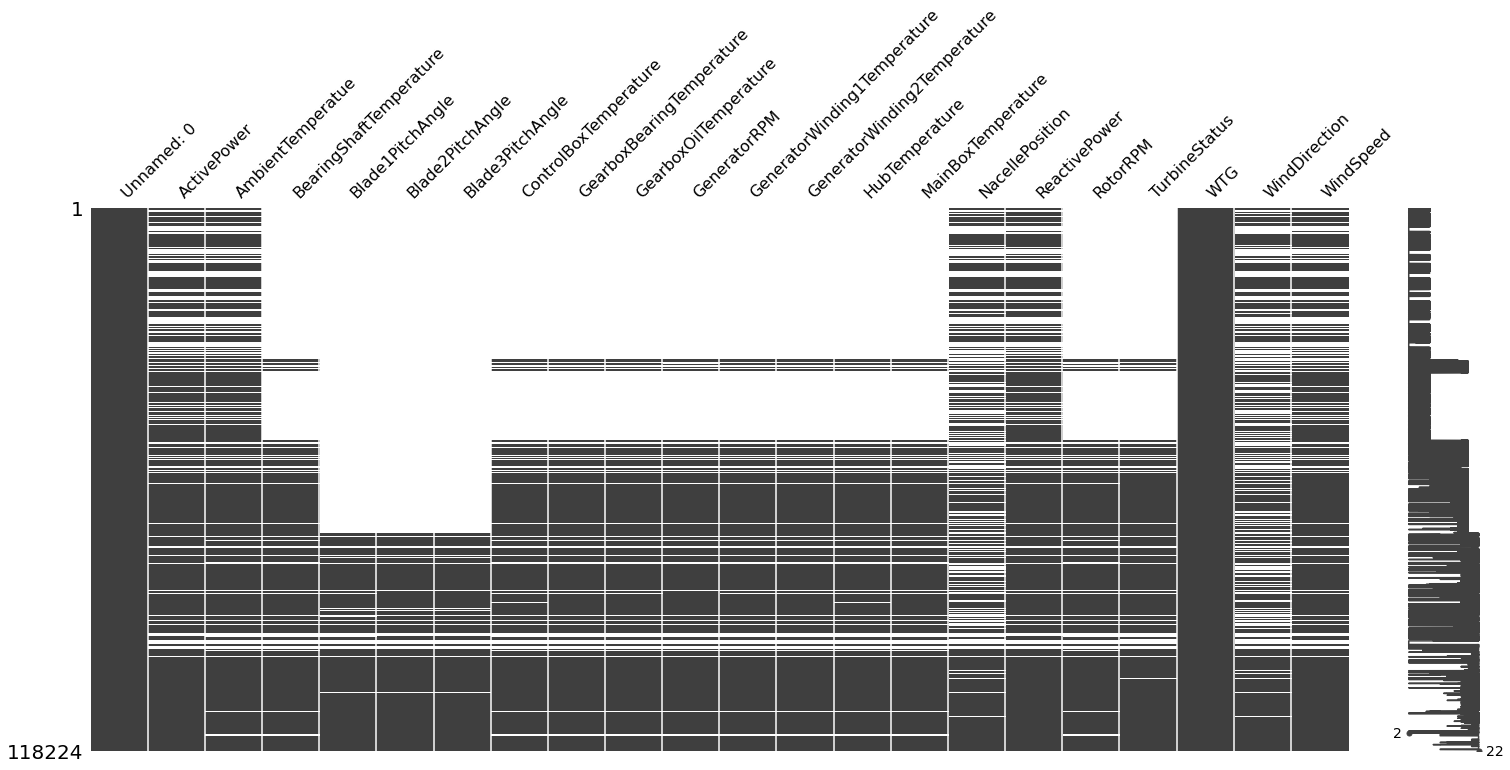

In [4]:
#the dataset shows 118224 observations for 22 features but some of the features have significant periods of missing data. We need to discard some periods and fill in the missing periods, otherwise our LSTM model will not converge or we may end up feeding it with garbage data.
#the rightmost part of the msno matrix plot shows completess of data, it indicates that the last half of dataset is more complete. We will strive to use this part for training and testing.
msno.matrix(series)

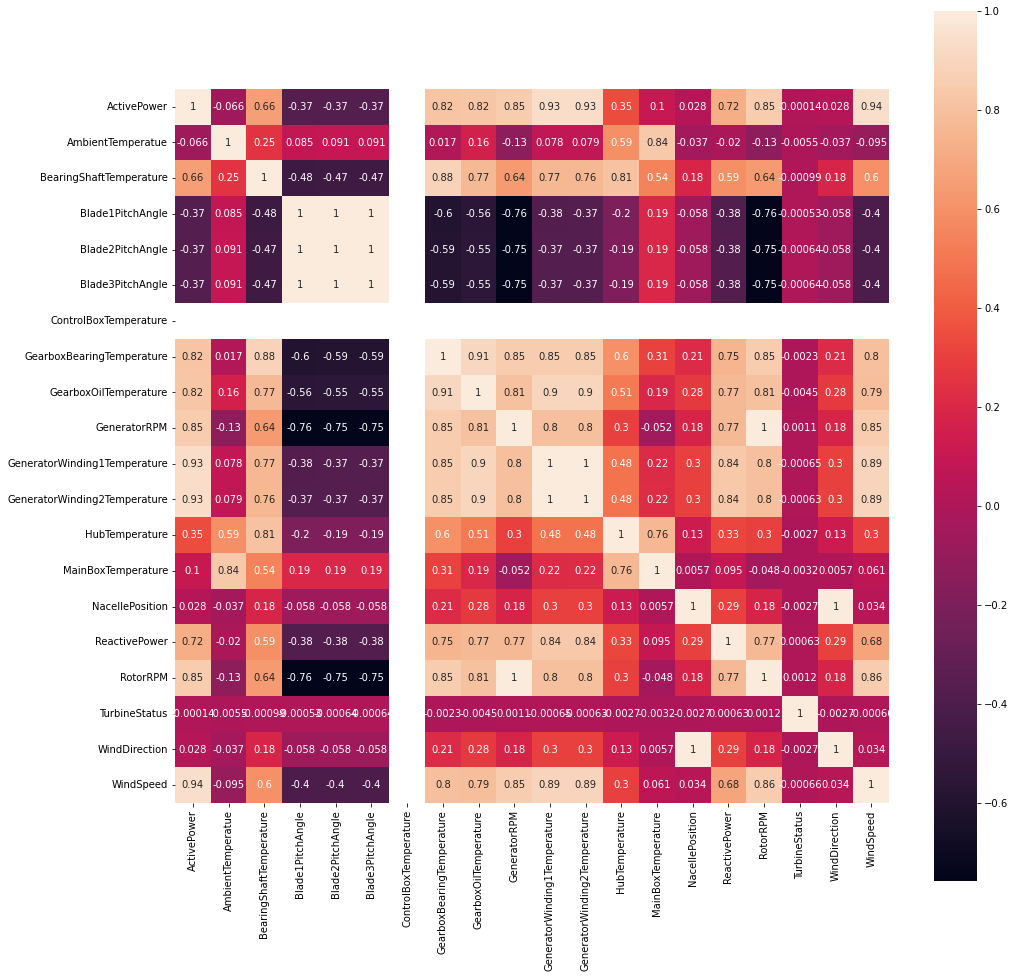

In [5]:
#correlation plot shows high positive correlation between a number of features, which will make them redundant. Discarting these features will help avoid the curse of dimensionality.
#For this demonstration, we will only focus on the Target Y - "ActivePower", and Predictor feature - "WindSpeed". This further simplifies our task.
#If you happen to have the mechanical engineering expertise knowledge about wind turbines, you will know that the wind power out is mostly dependent upon the weather conditions (e.g., wind speed), and you can therefore you can discard the rest of features.
plt.subplots(figsize=(16, 16))
sns.heatmap(series.corr(), annot=True, square=True)
plt.show()

# Pre-processing 

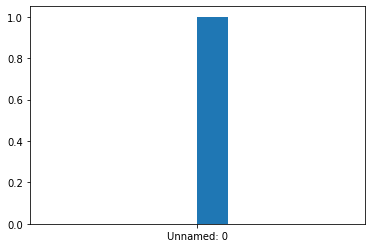

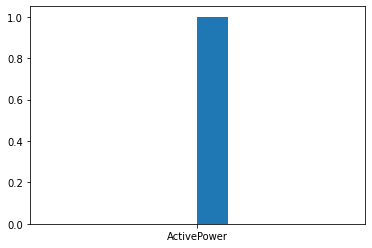

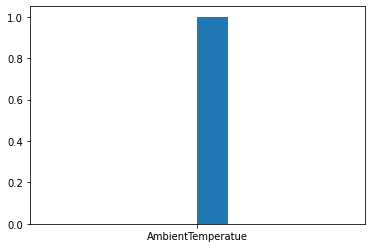

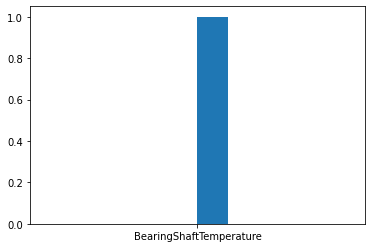

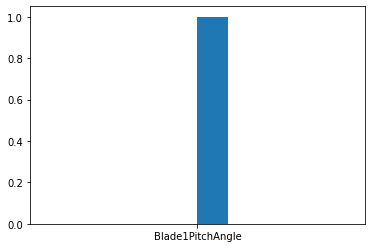

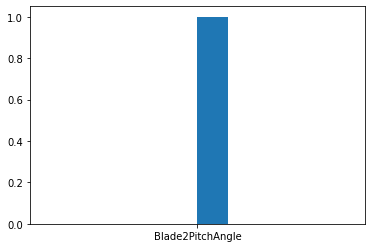

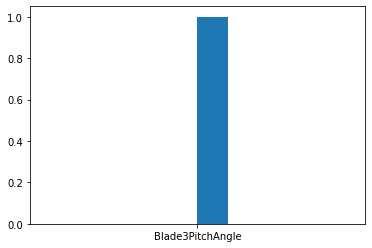

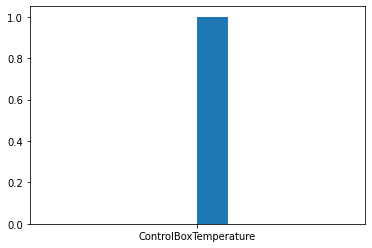

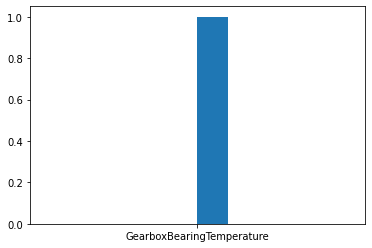

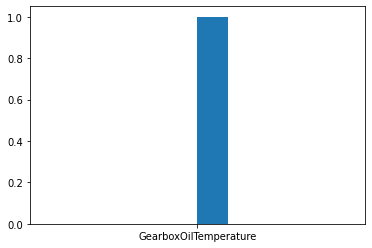

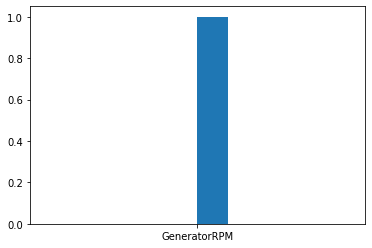

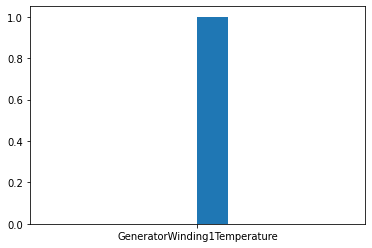

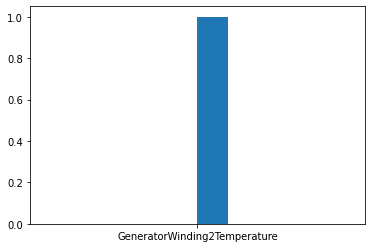

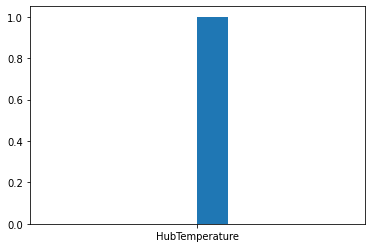

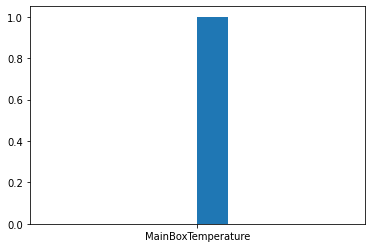

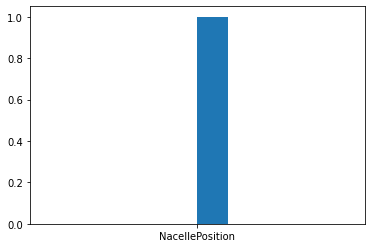

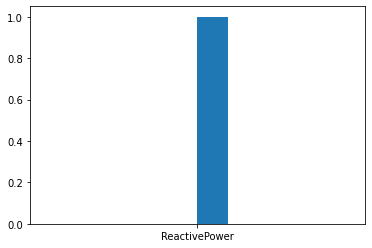

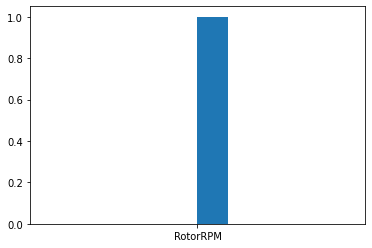

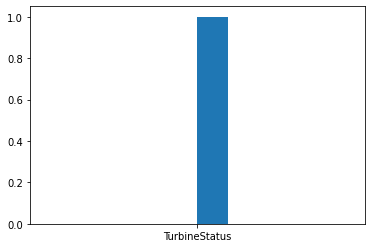

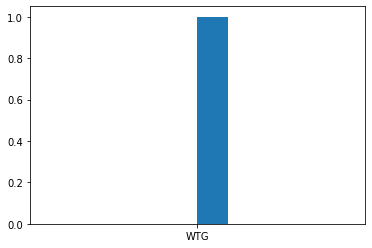

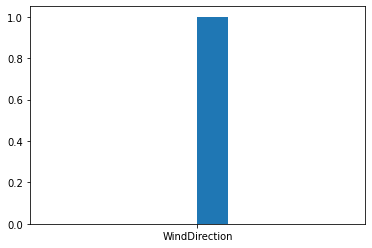

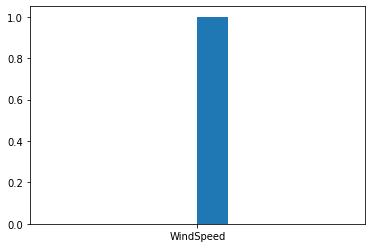

In [45]:
for x in range(0, len(series.columns)):
    plt.hist(series.columns[x])
    plt.show()

In [6]:
idxs = []

# we first get rid of all features that have no correlation with the active power
for i, corr in enumerate(series.corr()['ActivePower']):
    if corr > 0 and pd.notna(corr):
        idxs.append(i)
        
idxs = idxs[1:]
selected_features = series.corr()['ActivePower'][idxs]

# now we can cualitatively eliminate some features that are redundant, i.e. they have high correlation 
# and they physically correspond to a similar event (gearbox bearing T and gearbox oil T)
selected_features = selected_features.drop(labels=['GearboxOilTemperature', 'GeneratorWinding1Temperature', 'RotorRPM', 'NacellePosition'])
sel_feature_names = [idx for idx, val in selected_features.iteritems()]
#don't forget ActivePower
sel_feature_names.insert(0, 'ActivePower')
reduced_df = series[sel_feature_names]
print(f"The selected features are:\n{sel_feature_names}")

The selected features are:
['ActivePower', 'BearingShaftTemperature', 'GearboxBearingTemperature', 'GeneratorRPM', 'GeneratorWinding2Temperature', 'HubTemperature', 'MainBoxTemperature', 'ReactivePower', 'WindDirection', 'WindSpeed']


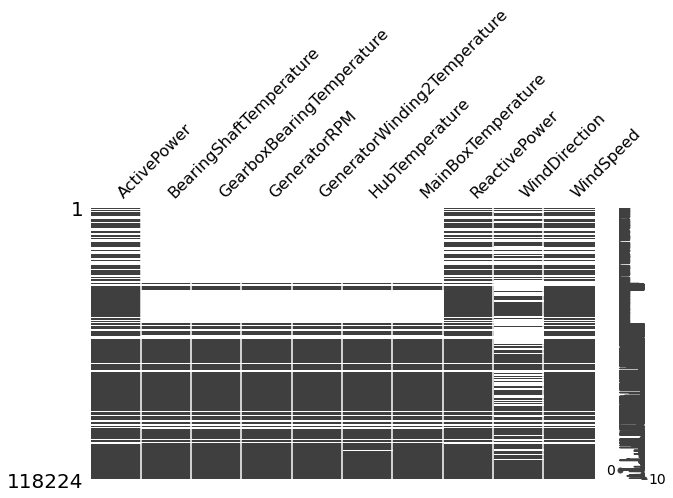

In [7]:
# we can see that there are still some big chunks of missing data among our selected features
msno.matrix(reduced_df, figsize=(10,5))
plt.show()

In [8]:
'''pre-processing from the baseline'''

#generate timestamp for the observations mimicking the "unnamed:0" feature
rng = pd.date_range('2017-12-31', periods=118224, freq='10T')
time_df = pd.DataFrame(rng)
#fill in missing values with zero using the fillforward function
reduced_df = reduced_df.fillna(0).astype(float)
#concatenate both the timestamp range and filled in features
reduced_df = pd.concat((time_df, reduced_df), axis=1)
#set up index
reduced_df = reduced_df.set_index(0)
#select a subset of data period from second half of original dataset, to ensure we have better quality signal (see completness comment of msno matrix plot above in the code)
reduced_df = reduced_df.loc['2019-12-17':]

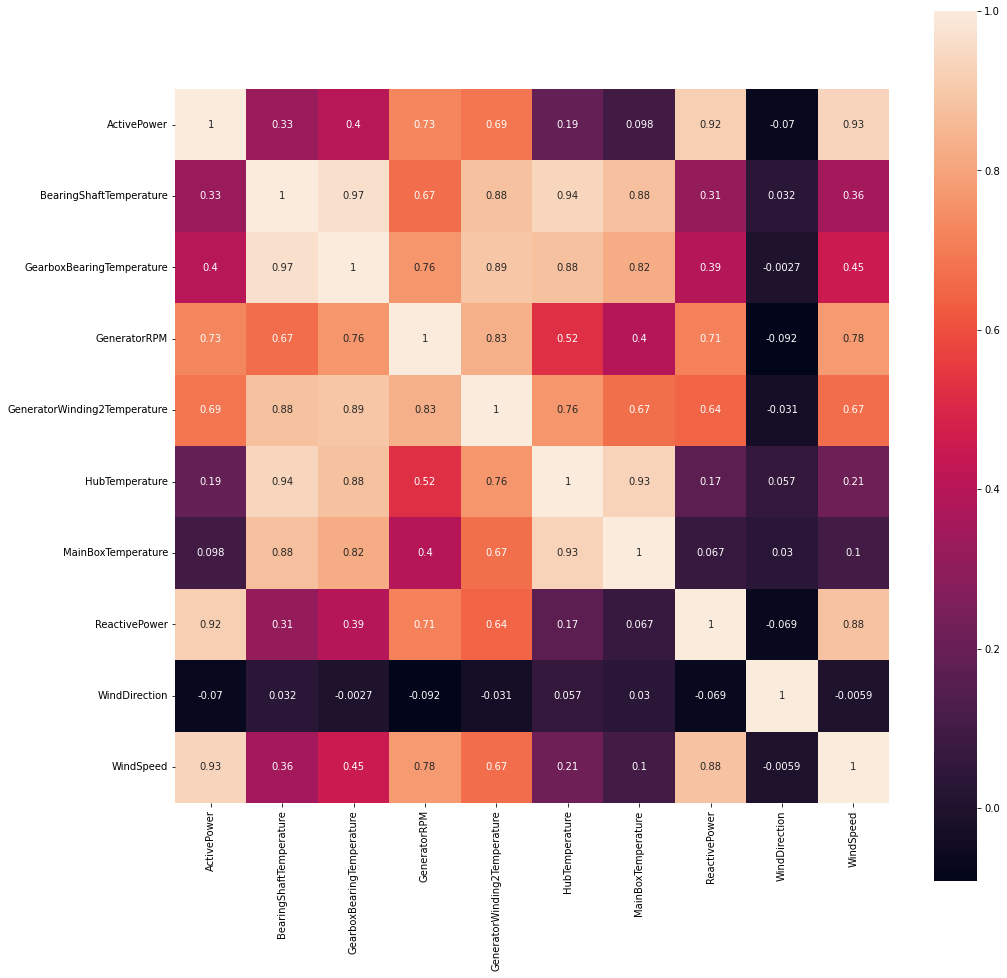

In [47]:
# we can see that there are still some big chunks of missing data among our selected features
plt.subplots(figsize=(16, 16))
sns.heatmap(reduced_df.corr(), annot=True, square=True)
plt.show()

### Util functions

In [9]:
def forecast_accuracy(forecast, actual):
    '''
    # (Recycled from notebook) Returns evaluation metrics given predicted and true values.
    '''

    forecast = np.array(forecast)
    actual = np.array(actual)
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    
    me = np.mean(forecast - actual)             # ME
    
    mae = np.mean(np.abs(forecast - actual))    # MAE
    
    mpe = np.mean((forecast - actual)/actual)   # MPE
    
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

# scales back from normalized values
def invert_values(y_pred, y_test, scaler) -> tuple:
    '''
    De-normalizes the predicted and true values given a scaler. 
    '''
    n_ahead = 144
    rng = pd.date_range('2017-12-31', periods=118224, freq='10T')
    time_df = pd.DataFrame(rng)

    # Creating the predictions date range
    days = time_df.values[-len(y_pred):-len(y_pred) + n_ahead]
    days_df = pd.DataFrame(days)

    pred_n_ahead = pd.DataFrame(y_pred)
    actual_n_ahead = pd.DataFrame(y_test)

    #repeat the column series n times (being n the number of features used), to make shape compatible for scale inversion
    pr_p = pd.concat([pred_n_ahead]*len(sel_feature_names), axis=1)
    ac_p = pd.concat([actual_n_ahead]*len(sel_feature_names), axis=1)

    #inverse scale tranform the series back to kiloWatts of power
    pred_power = scaler.inverse_transform(pr_p)[:,0]
    actual_power = scaler.inverse_transform(ac_p)[:,0]
    
    return pred_power, actual_power



def plot_random_predictions(pred_power, actual_power, n_predictions=6):
    '''
    Plots the prediction of 6 randomly selected days (out of the 21 predicted)
    The zeros that are filled in during pre-processing are marked in lime green
    '''
    if n_predictions > 21:
        print('Error: there are only 21 days in the predicted set')
        return
    
    # 21 days in total
    days = np.arange(0,21)
    np.random.shuffle(days)

    # we assume hard zeros are the ones forced by pre-processing
    cond_color = np.where(actual_power==0, 'lime', plt.rcParams['axes.prop_cycle'].by_key()['color'][0])

    fig, ax = plt.subplots(3,2, figsize=(30, 20))

    ax_h = 0
    ax_v = 0
    for i in range(0,n_predictions):
        ax[ax_h,ax_v].plot(rng[days[i]*144:(days[i]+1)*144], actual_power[days[i]*144:(days[i]+1)*144], label="actual")
        ax[ax_h,ax_v].scatter(rng[days[i]*144:(days[i]+1)*144], actual_power[days[i]*144:(days[i]+1)*144], color=cond_color[days[i]*144:(days[i]+1)*144])
        ax[ax_h,ax_v].plot(rng[days[i]*144:(days[i]+1)*144], pred_power[days[i]*144:(days[i]+1)*144], marker='o', label="prediction")
        ax[ax_h,ax_v].legend()
        ax[ax_h,ax_v].set_title(f"Predicted vs. Actual Power (Day {days[i]+1})")
        ax[ax_h,ax_v].set_xlabel("Time")
        ax[ax_h,ax_v].set_ylabel("Power (kW)")
        if i%2 == 0:
            ax_v = 1
        else:
            ax_h += 1
            ax_v = 0

    plt.show()

In [10]:
# Scaling data between 0 and 1
scaler = MinMaxScaler()
scaler.fit(reduced_df.values)
data_scaled = scaler.transform(reduced_df.values)

The are 105 days in total, so it's easier to split them by number of days instead of using a proportion which may cut a day if the resulting shape is not a multiple of 144

In [11]:
# we split the data twice: for regression and for training of nn

test_split_days = 21 # 20%
val_split_days = 10 # around 10%

test_split_idx = len(reduced_df)-144*test_split_days
val_split_idx = test_split_idx-144*val_split_days

print("-- Regression --")
train_data = data_scaled[:test_split_idx]
test_data = data_scaled[test_split_idx:]
print(f"Train data shape: {train_data.shape}\nTest data shape: {test_data.shape}\n")

print("-- NN --")
train_data_nn = data_scaled[:val_split_idx]
val_data_nn = data_scaled[val_split_idx:test_split_idx]
test_data_nn = data_scaled[test_split_idx:]
print(f"Train data shape: {train_data_nn.shape}\nVal data shape: {val_data_nn.shape}\nTest data shape: {test_data_nn.shape}")

-- Regression --
Train data shape: (12096, 10)
Test data shape: (3024, 10)

-- NN --
Train data shape: (10656, 10)
Val data shape: (1440, 10)
Test data shape: (3024, 10)


In [12]:
print("-- Regression --")
x_train, y_train = train_data[:,1:], train_data[:,0]
print(f"Train values shape: {x_train.shape}\nTrain labels shape: {y_train.shape}")

x_test, y_test = test_data[:,1:], test_data[:,0]
print(f"Test values shape: {x_train.shape}\nTest labels shape: {y_train.shape}\n")

print("-- NN --")
x_train_nn, y_train_nn = train_data_nn[:,1:], train_data_nn[:,0]
print(f"Train values shape: {x_train_nn.shape}\nTrain labels shape: {y_train_nn.shape}")

x_val_nn, y_val_nn = val_data_nn[:,1:], val_data_nn[:,0]
print(f"Val values shape: {x_val_nn.shape}\nVal labels shape: {y_val_nn.shape}")

x_test_nn, y_test_nn = test_data_nn[:,1:], test_data_nn[:,0]
print(f"Test values shape: {x_test_nn.shape}\nTest labels shape: {y_test_nn.shape}\n")


-- Regression --
Train values shape: (12096, 9)
Train labels shape: (12096,)
Test values shape: (12096, 9)
Test labels shape: (12096,)

-- NN --
Train values shape: (10656, 9)
Train labels shape: (10656,)
Val values shape: (1440, 9)
Val labels shape: (1440,)
Test values shape: (3024, 9)
Test labels shape: (3024,)



# First model: Support Vector Regression (SVR)

#### This code was used to obtain the best parameters for SVR

In [13]:
'''cv_params = {'epsilon': np.linspace(0,0.1,9),'C': np.linspace(1,10,10)}
# 84 folds would take a day per fold. Therefore we take lower multiples
grid = GridSearchCV(SVR(), cv_params, scoring='neg_mean_absolute_error', cv=21, n_jobs=4, verbose=1) # 4 days per fold
grid.fit(x_train, y_train)
print(f"The best model has parameters C={grid.best_params_['C']} and epsilon={grid.best_params_['epsilon']}")

# predict using the best model
#y_pred_svr = grid.best_estimator_.predict(x_test)''';

#### Using the best parameters directly

In [14]:
svr_model = SVR(epsilon=0.0, C=2.0)
svr_model.fit(x_train, y_train)

#predict
y_pred_svr = svr_model.predict(x_test)

# de-normalize values
pred_power_svr, actual_power_svr = invert_values(y_pred_svr, y_test, scaler)

# get scores
forecast_accuracy(pred_power_svr, actual_power_svr)

{'mape': inf,
 'me': -8.785025909244736,
 'mae': 20.218748989534372,
 'mpe': nan,
 'rmse': 50.268098400215244,
 'corr': 0.9960319709008448,
 'minmax': inf}

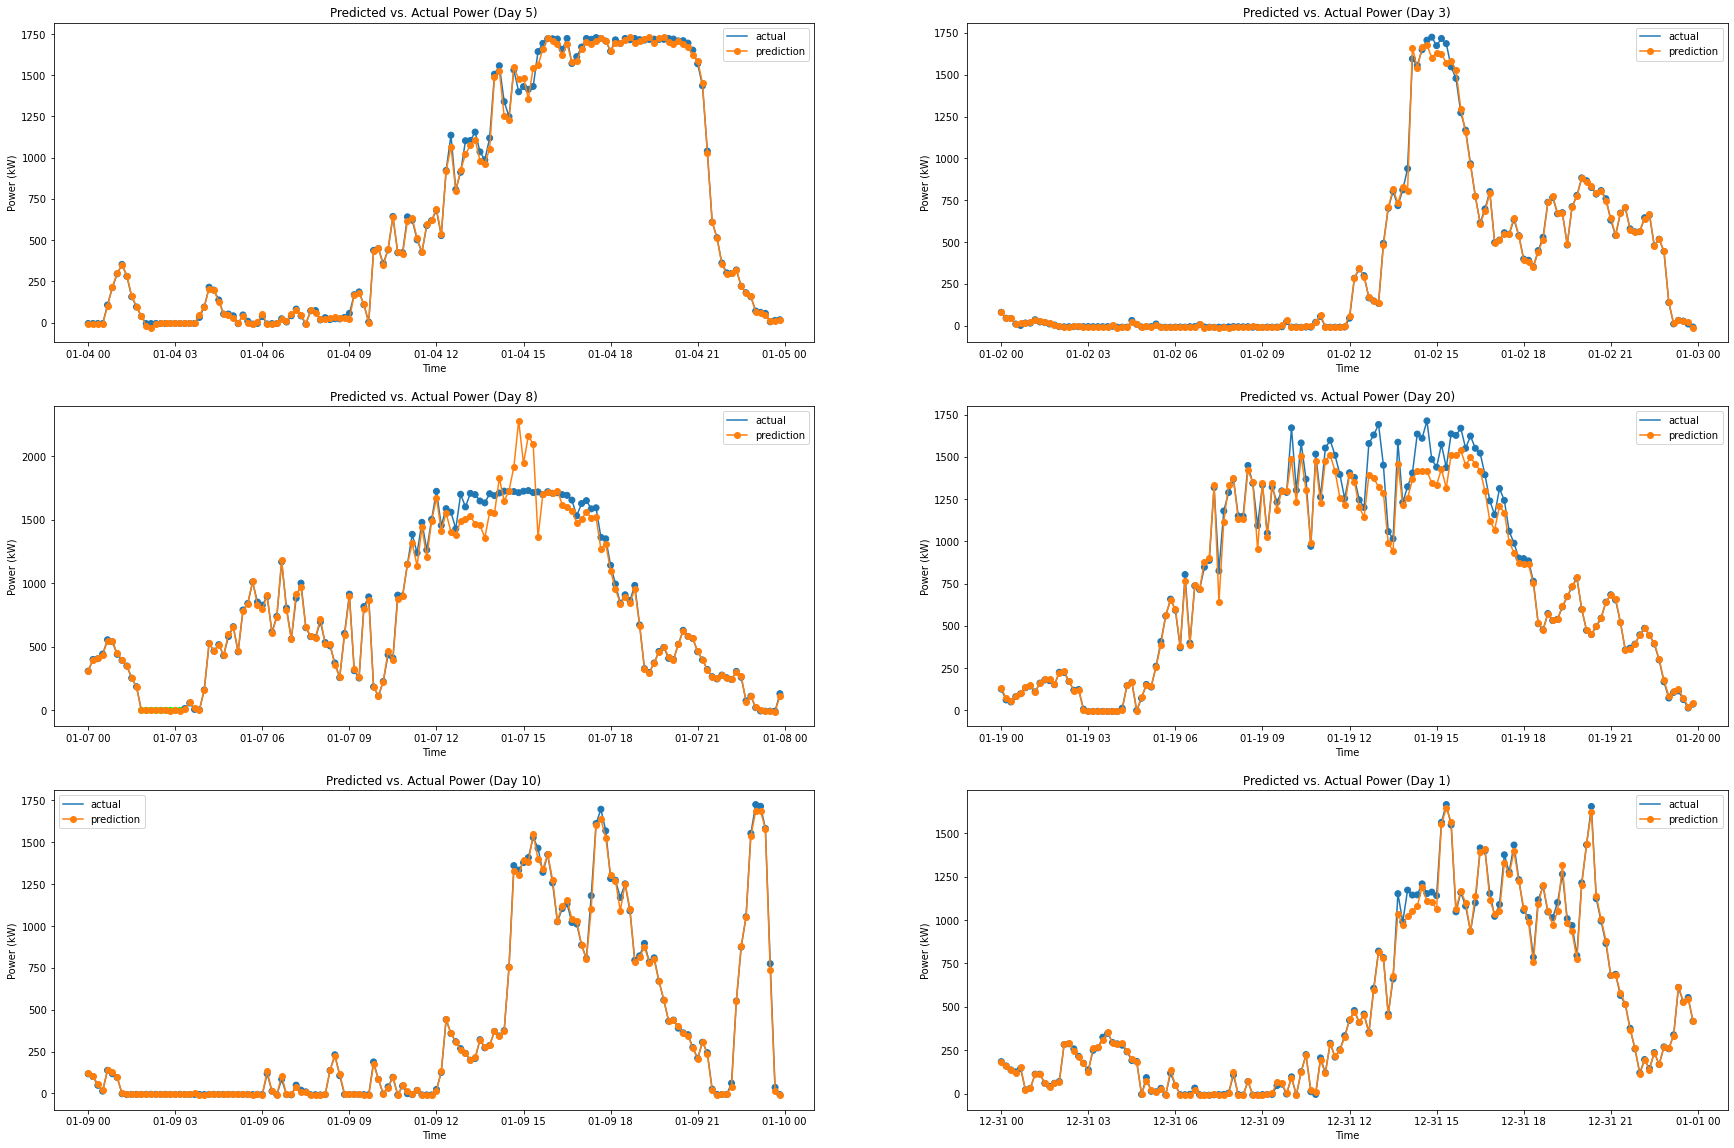

In [15]:
plot_random_predictions(pred_power_svr, actual_power_svr)

### Residuals analysis

In [16]:
residuals_svr = pd.Series(pred_power_svr-actual_power_svr)
residuals_svr.describe()

count    3024.000000
mean       -8.785026
std        49.502681
min      -599.853189
25%        -8.279235
50%        -0.466978
75%         3.719872
max       661.374803
dtype: float64

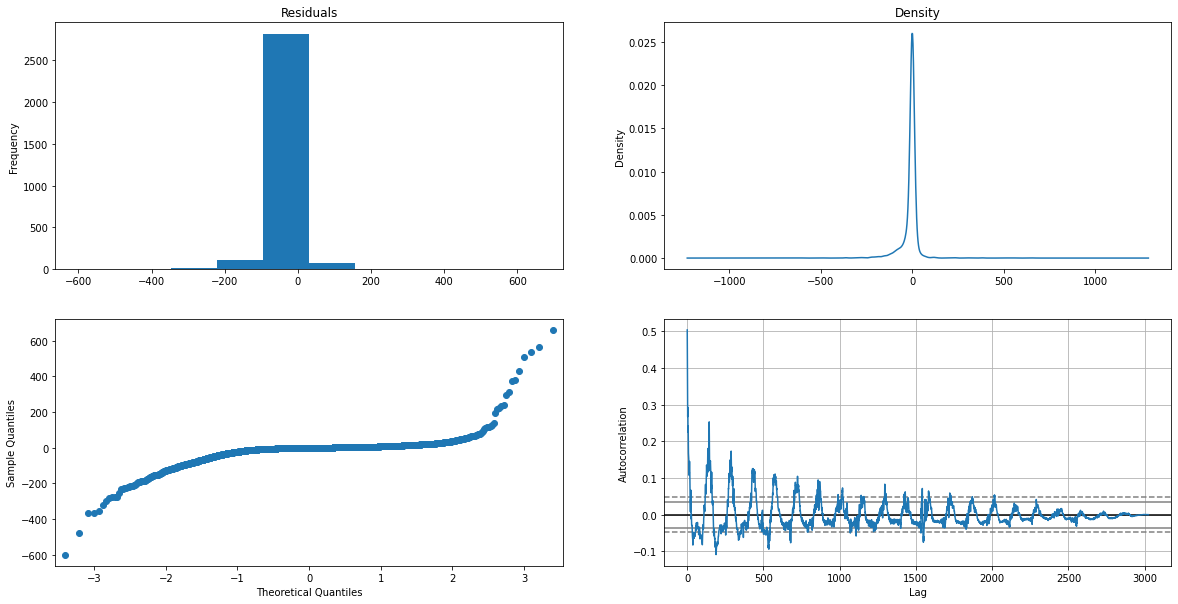

In [17]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
residuals_svr.plot(kind='hist', title="Residuals", ax=ax[0,0])
residuals_svr.plot(kind='kde', title='Density', ax=ax[0,1])
qqplot(residuals_svr, ax=ax[1,0])
autocorrelation_plot(residuals_svr, ax=ax[1,1])
plt.show()

**By analysing the result, we can conclude that this method works quite well. The RMSE is drastically reduced, as well as the mean error, meaning that the prediction is better overall. The correlation metric shows that the predictions are very close to the actual values. The MAPE and MPE don't give useful result since the true power output is sometimes zero.**

**Looking at the graphs with predictions vs. actual values, as well as at the residuals, we can see that the residuals have zero mean and a small variance, which is indeed a good sign since the error margins are minimal. However, The QQ plot indicates that the model has trouble handling extreme values. That can be confirmed in the previously mentioned plot, where the errors are located in zones containing those. The autocorrelation shows how the lagged information is well included in the predictions.**

**Our interest now lies in finding a better model that is able to predict the extreme values as well as keeping the rest of prediction accurate**

# GRU model


**Let's try with a GRU model, which is basically the same as LSTM, but a bit simpler and shown to be more efficient.**

We need to re-do the splitting, to count with a validation split. Reshaping is also necessary for inputting single days of data into the network

In [18]:
# reshape training data to feed days individually
x_train_reshaped, x_val_reshaped, x_test_reshaped = x_train_nn.reshape(-1, 144, 9), x_val_nn.reshape(-1, 144, 9), x_test_nn.reshape(-1, 144, 9)
y_train_reshaped, y_val_reshaped, y_test_reshaped = y_train_nn.reshape(-1, 144), y_val_nn.reshape(-1, 144), y_test_nn.reshape(-1, 144)

In [19]:
## model parameters ##
depth = 2

# created the GRU model
model_gru = Sequential()

for i in range(1, depth+1):

    # we leave the standard arguments for GPU speeding up
    model_gru.add(GRU(units=64, input_shape=x_train_reshaped.shape[1:], return_sequences=True))
    model_gru.add(BatchNormalization())
    model_gru.add(Dropout(0.4))   

# maps every neuron to a single output (predicted time series)
model_gru.add(Dense(units=1))

model_gru.summary()
#plot_model(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 144, 64)           14400     
                                                                 
 batch_normalization (BatchN  (None, 144, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 144, 64)           0         
                                                                 
 gru_1 (GRU)                 (None, 144, 64)           24960     
                                                                 
 batch_normalization_1 (Batc  (None, 144, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 144, 64)           0

In [20]:
# training parameters
lr = 1e-3
loss = 'mae'
metrics = 'mae'

# compile and additional parameters
patience = 5
min_delta_patience = 1e-4
checkpoint_path = 'best_gru.hdf5'

weights_save = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, min_delta=min_delta_patience)
model_gru.compile(optimizer=adam_v2.Adam(learning_rate=lr), loss=loss, metrics=metrics)

Epoch 1/50
74/74 [==============================] - 9s 81ms/step - loss: 0.8923 - mae: 0.8923 - val_loss: 0.2083 - val_mae: 0.2083
Epoch 2/50
74/74 [==============================] - 5s 71ms/step - loss: 0.6388 - mae: 0.6388 - val_loss: 0.2312 - val_mae: 0.2312
Epoch 3/50
74/74 [==============================] - 5s 69ms/step - loss: 0.4704 - mae: 0.4704 - val_loss: 0.1910 - val_mae: 0.1910
Epoch 4/50
74/74 [==============================] - 5s 67ms/step - loss: 0.3313 - mae: 0.3313 - val_loss: 0.1768 - val_mae: 0.1768
Epoch 5/50
74/74 [==============================] - 5s 66ms/step - loss: 0.2286 - mae: 0.2286 - val_loss: 0.1396 - val_mae: 0.1396
Epoch 6/50
74/74 [==============================] - 5s 66ms/step - loss: 0.1659 - mae: 0.1659 - val_loss: 0.1114 - val_mae: 0.1114
Epoch 7/50
74/74 [==============================] - 5s 68ms/step - loss: 0.1382 - mae: 0.1382 - val_loss: 0.1041 - val_mae: 0.1041
Epoch 8/50
74/74 [==============================] - 5s 67ms/step - loss: 0.1235 - m

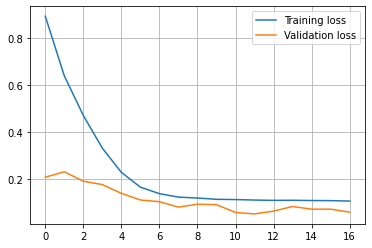

In [21]:
# running parameters
batch_size = 1 # this is done because we want 1 step predictions, therefore we need to update for every step
epochs = 50

history_gru = model_gru.fit(x_train_reshaped,
                    y_train_reshaped,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val_reshaped, y_val_reshaped),
                    shuffle=False,
                    callbacks=[early_stopping, weights_save])

plt.plot(history_gru.history['loss'], label='Training loss')
plt.plot(history_gru.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.grid()
plt.show()

model_gru.load_weights(checkpoint_path)

In [22]:
y_pred_gru = model_gru.predict(x_test_reshaped)
pred_power_gru, actual_power_gru = invert_values(y_pred_gru.reshape(-1, ), y_test_nn, scaler)

forecast_accuracy(pred_power_gru, actual_power_gru)

{'mape': inf,
 'me': -61.430681622042854,
 'mae': 105.60218414722523,
 'mpe': -inf,
 'rmse': 233.16784051984322,
 'corr': 0.9085204937934698,
 'minmax': inf}

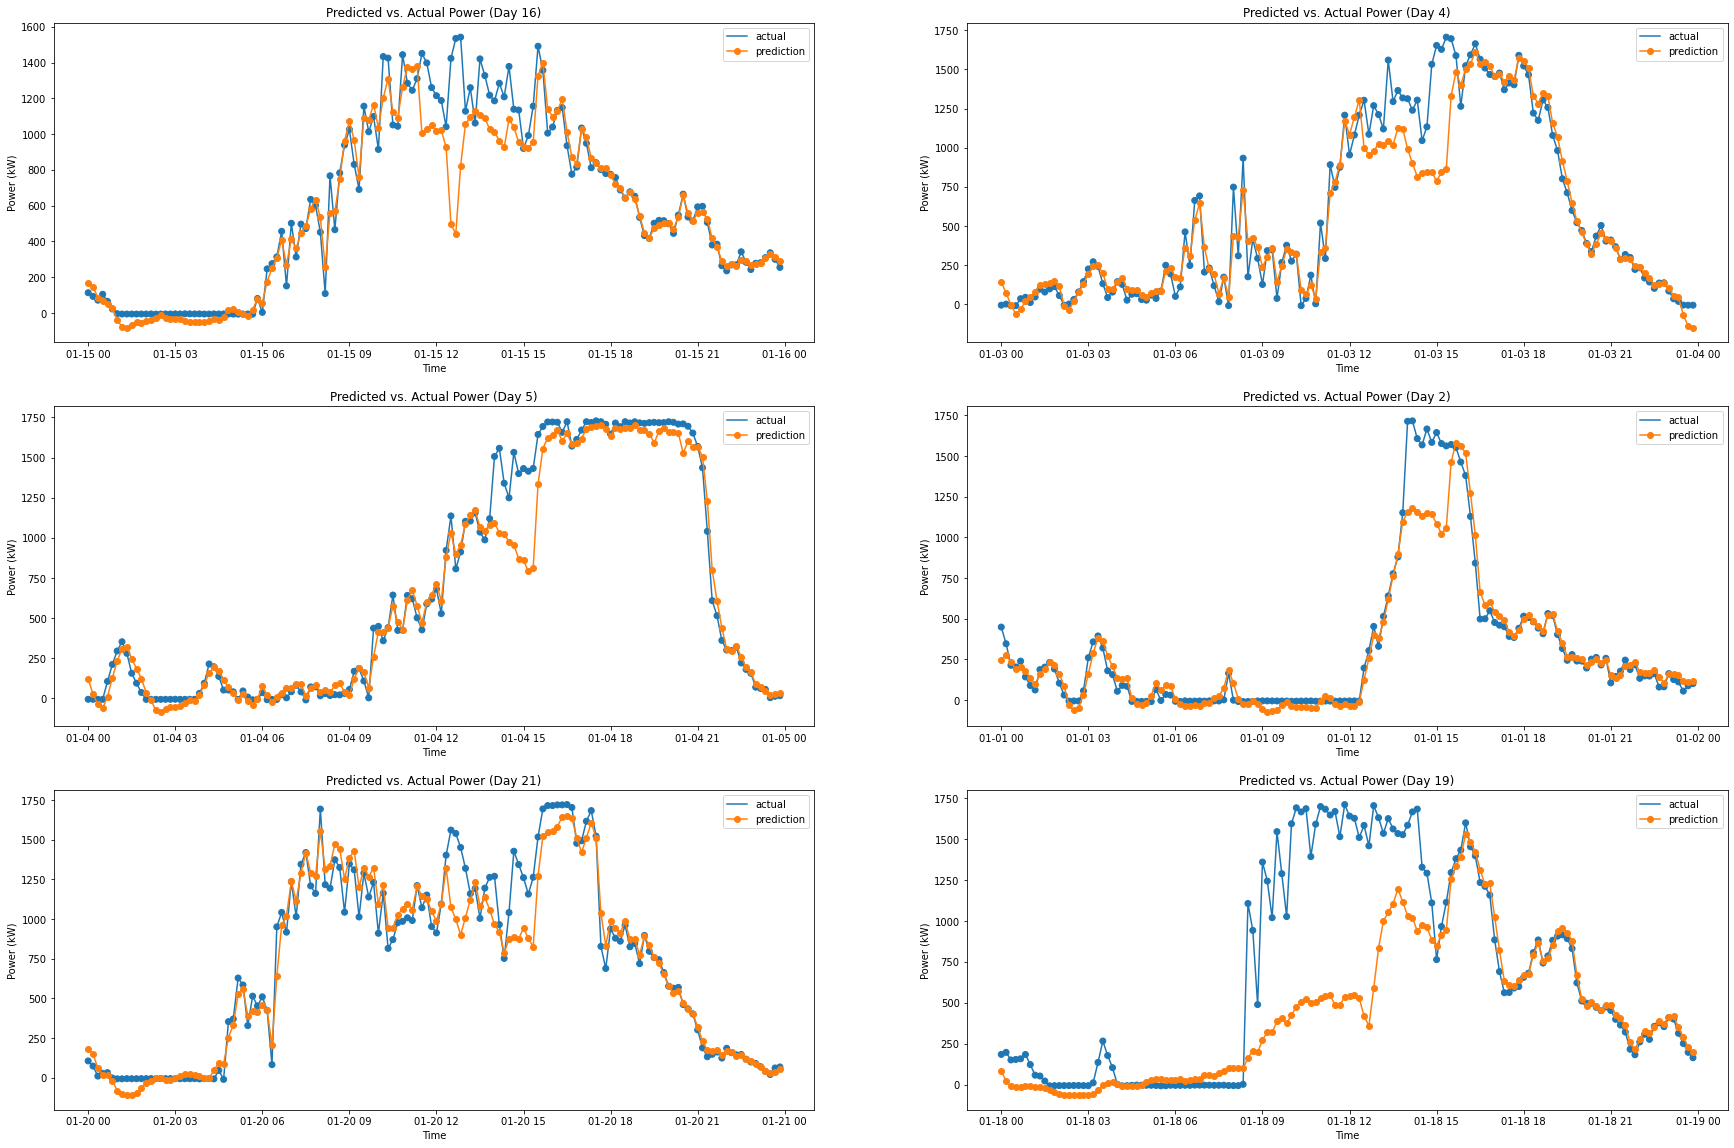

In [23]:
plot_random_predictions(pred_power_gru, actual_power_gru)

In [24]:
residuals_gru = pd.Series(pred_power_gru-actual_power_gru)
residuals_gru.describe()

count    3024.000000
mean      -61.430682
std       224.967219
min     -1587.206622
25%       -45.316375
50%        -3.115058
75%        33.485659
max       541.198100
dtype: float64

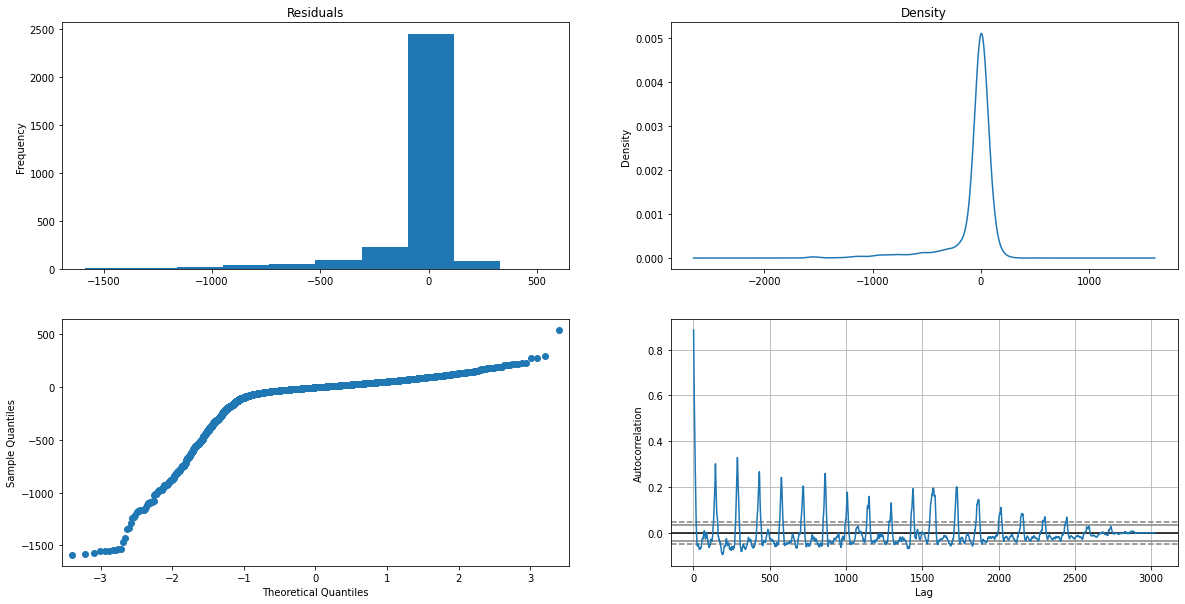

In [25]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
residuals_gru.plot(kind='hist', title="Residuals", ax=ax[0,0])
residuals_gru.plot(kind='kde', title='Density', ax=ax[0,1])
qqplot(residuals_gru, ax=ax[1,0])
autocorrelation_plot(residuals_gru, ax=ax[1,1])
plt.show()

**After validation, the best architecture is a 2-layer with 64 units in each layer. Shallower models did not fit the curve well, while deep ones were overfitting and predicting completely wrong. This model captures well the data, but cannot reduce the error as well as the SVR model. the QQ plot shows how the extreme values are handled a bit better, but autocorrelation shows that the lagged values are integrated worse in the model.**


**Looking at the training history, maybe a bit of overfitting can be observed in the validation curve since it oscillates slightly.**

# LSTM

We want to check whether GRU indeed outperforms LSTM so that we can discard it

In [26]:
# model parameters
depth = 2

#create the LSTM model
model_lstm = Sequential()

for i in range(1, depth+1):

    model_lstm.add(LSTM(units=64, input_shape=x_train_reshaped.shape[1:], return_sequences=True))
    model_lstm.add(BatchNormalization())
    model_lstm.add(Dropout(0.4))

# maps every neuron to a single output (predicted time series)
model_lstm.add(Dense(units=1))

model_lstm.summary()
#plot_model(model_lstm)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 144, 64)           18944     
                                                                 
 batch_normalization_2 (Batc  (None, 144, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 144, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 144, 64)           33024     
                                                                 
 batch_normalization_3 (Batc  (None, 144, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 144, 64)          

In [27]:
# training parameters
lr = 1e-3
loss = 'mae'
metrics = 'mae'

# compile and additional parameters
patience = 5
min_delta_patience = 1e-4
checkpoint_path = 'best_lstm.hdf5'

weights_save = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, min_delta=min_delta_patience)
model_lstm.compile(optimizer = adam_v2.Adam(learning_rate=lr), loss=loss, metrics=metrics)

Epoch 1/50
74/74 [==============================] - 10s 88ms/step - loss: 0.8675 - mae: 0.8675 - val_loss: 0.2370 - val_mae: 0.2370
Epoch 2/50
74/74 [==============================] - 5s 71ms/step - loss: 0.5610 - mae: 0.5610 - val_loss: 0.2393 - val_mae: 0.2393
Epoch 3/50
74/74 [==============================] - 5s 71ms/step - loss: 0.3943 - mae: 0.3943 - val_loss: 0.2245 - val_mae: 0.2245
Epoch 4/50
74/74 [==============================] - 5s 71ms/step - loss: 0.2956 - mae: 0.2956 - val_loss: 0.2095 - val_mae: 0.2095
Epoch 5/50
74/74 [==============================] - 5s 72ms/step - loss: 0.2346 - mae: 0.2346 - val_loss: 0.1751 - val_mae: 0.1751
Epoch 6/50
74/74 [==============================] - 5s 73ms/step - loss: 0.2040 - mae: 0.2040 - val_loss: 0.1699 - val_mae: 0.1699
Epoch 7/50
74/74 [==============================] - 5s 72ms/step - loss: 0.1719 - mae: 0.1719 - val_loss: 0.2172 - val_mae: 0.2172
Epoch 8/50
74/74 [==============================] - 5s 70ms/step - loss: 0.1624 - 

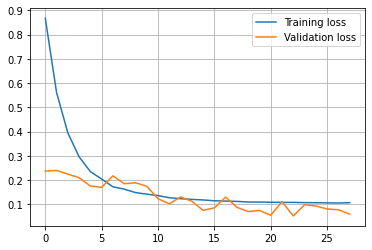

In [28]:
# running time
batch_size = 1 # this is done because we want 1 step predictions, therefore we need to update for every step
epochs = 50

history_lstm = model_lstm.fit(x_train_reshaped,
                              y_train_reshaped,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(x_val_reshaped, y_val_reshaped),
                              shuffle=False,
                              callbacks=[early_stopping, weights_save])

plt.plot(history_lstm.history['loss'], label='Training loss')
plt.plot(history_lstm.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.grid()
plt.show()

model_lstm.load_weights(checkpoint_path)

In [29]:
y_pred_lstm = model_lstm.predict(x_test_reshaped)
pred_power_lstm, actual_power_lstm = invert_values(y_pred_lstm.reshape(-1, ), y_test_nn, scaler)

forecast_accuracy(pred_power_lstm, actual_power_lstm)

{'mape': inf,
 'me': -11.198409195750585,
 'mae': 144.2253572575681,
 'mpe': -inf,
 'rmse': 229.24561079300642,
 'corr': 0.9049184377131019,
 'minmax': inf}

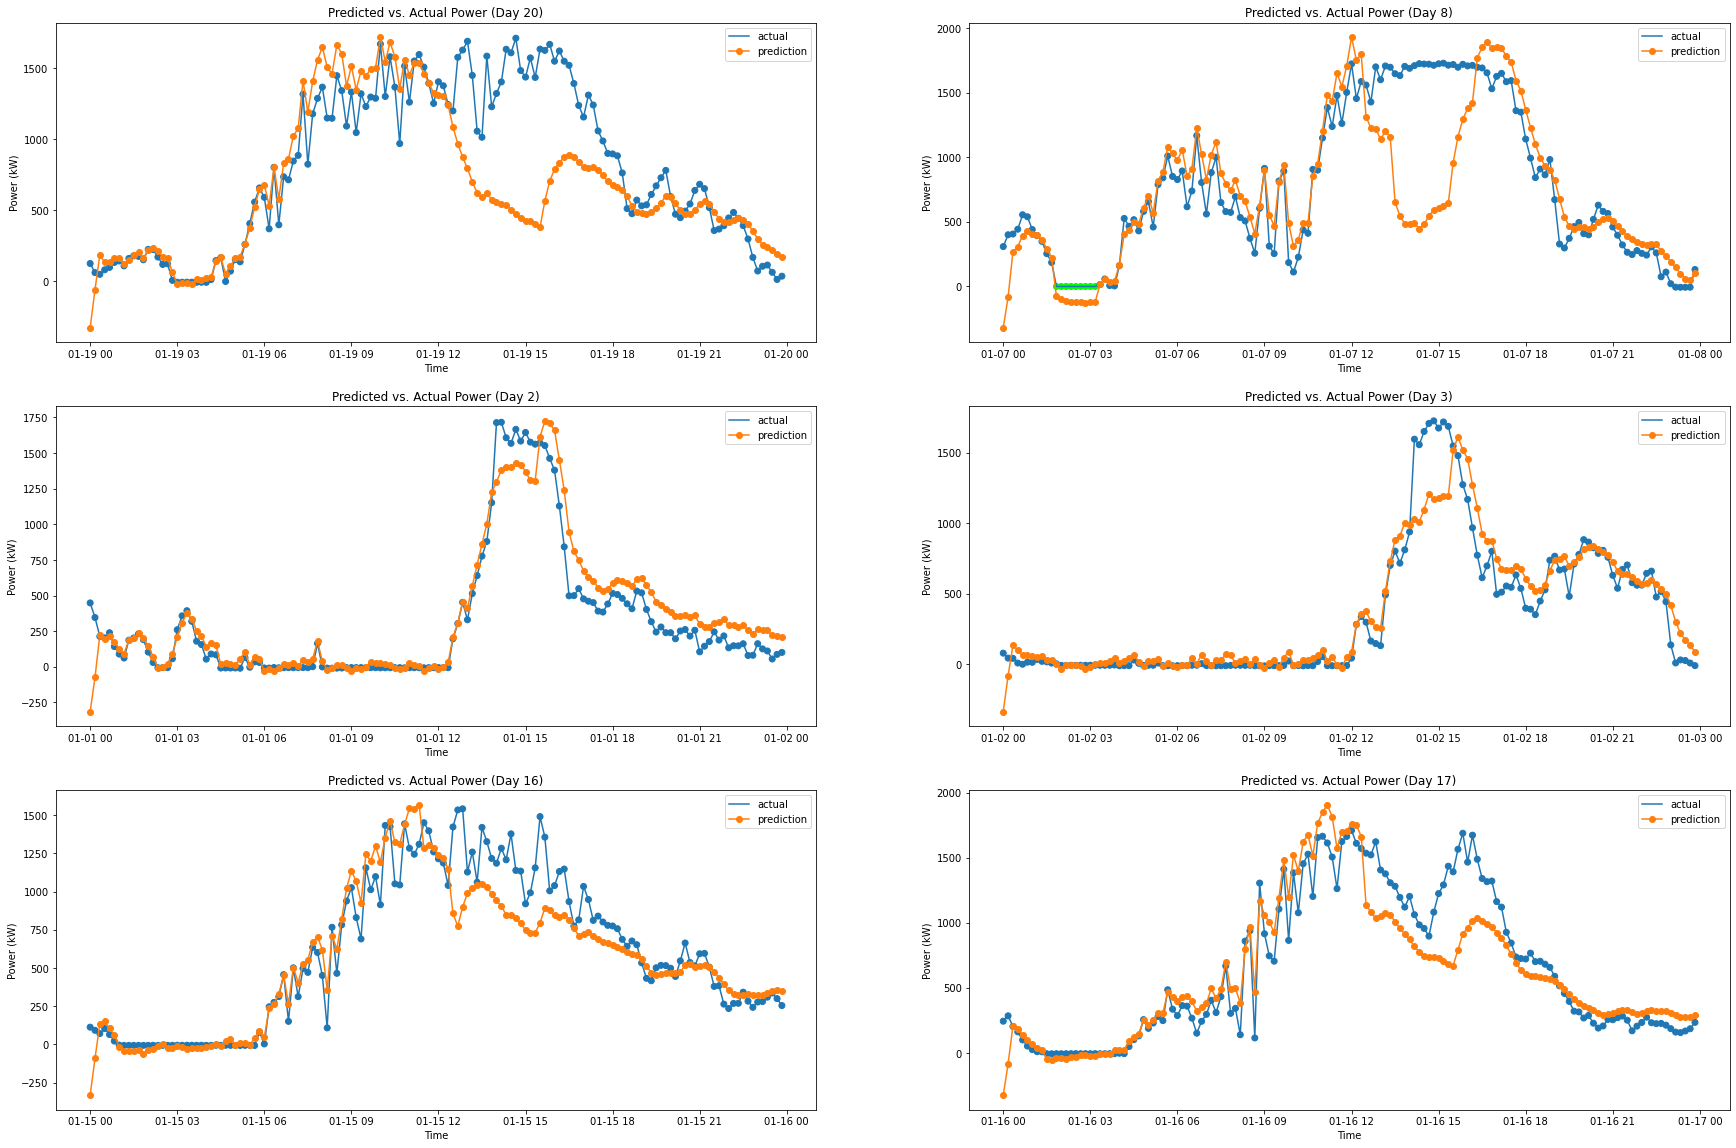

In [30]:
plot_random_predictions(pred_power_lstm, actual_power_lstm)

**LSTM isn't able to learn as easily as GRU, as it has more parameters and isn't that efficient. We can therefore discard it.**

# CNN

**We're going to try a final resort for a neural network to perform well. Here we're using Gramian Angular Fields to convert the time series to image of size _nxn_ being _n_ the number of features. These images transform therefore every time point to a pixel in a non-cartesian way. Considering than CNNs are quite powerful, maybe they are able to improve the score over RNNs.**

In [31]:
features_data = reduced_df.values[:,1:]

# GAF does min max scaling already
gadf_scaler = GAF(method='s', sample_range=(0,1))
gadf_scaler.fit(features_data)

# we have to reobtain the x_train, x_val and x_test, reshaping them to 4 dimensions to fit the input size
x_train_cnn = gadf_scaler.transform(features_data[:val_split_idx])
x_train_cnn = x_train_cnn.reshape(x_train_cnn.shape[0], x_train_cnn.shape[1], x_train_cnn.shape[2], 1)

x_val_cnn = gadf_scaler.transform(features_data[val_split_idx:test_split_idx])
x_val_cnn = x_val_cnn.reshape(x_val_cnn.shape[0], x_val_cnn.shape[1], x_val_cnn.shape[2], 1)

x_test_cnn = gadf_scaler.transform(features_data[test_split_idx:])
x_test_cnn = x_test_cnn.reshape(x_test_cnn.shape[0], x_test_cnn.shape[1], x_test_cnn.shape[2], 1)

In [32]:
### model parameters
depth = 3
kernel_size = (3,3)
lrelu_alpha = 0.2
dropout = 0.4
n_filters = 32

inputs = Input(shape=x_train_cnn.shape[1:])
b = inputs
for i in range(1, depth+1):

    a = Conv2D(filters=n_filters*i, kernel_size=kernel_size, activation=None)(b)
    x = LeakyReLU(alpha=lrelu_alpha)(a)
    x = BatchNormalization()(x)
    b = Dropout(dropout)(x)
    
a = Conv2D(filters=n_filters*(i+1), kernel_size=kernel_size, activation=None)(x)
x = LeakyReLU(alpha=lrelu_alpha)(a)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(dropout)(x)

outputs = Dense(units=1, activation='sigmoid')(x)

model_cnn = Model(inputs, outputs)

model_cnn.summary()
# plo

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9, 9, 1)]         0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 32)          0         
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 32)         128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 64)          18496     
                                                             

In [ ]:
# t_model(model_cnn)

In [33]:
# compile parameters
lr = 1e-4

# callbacks parameters 
patience = 10
min_delta_patience = 1e-4
loss = 'mae'
metrics = 'mae'
checkpoint_path = 'best_cnn.hdf5'

weights_save = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, min_delta=min_delta_patience)
model_cnn.compile(optimizer = adam_v2.Adam(learning_rate=lr), loss=loss, metrics=metrics)

Epoch 1/100
333/333 [==============================] - 6s 15ms/step - loss: 0.3456 - mae: 0.3456 - val_loss: 0.2829 - val_mae: 0.2829
Epoch 2/100
333/333 [==============================] - 5s 16ms/step - loss: 0.3088 - mae: 0.3088 - val_loss: 0.1521 - val_mae: 0.1521
Epoch 3/100
333/333 [==============================] - 6s 18ms/step - loss: 0.2896 - mae: 0.2896 - val_loss: 0.1654 - val_mae: 0.1654
Epoch 4/100
333/333 [==============================] - 5s 15ms/step - loss: 0.2744 - mae: 0.2744 - val_loss: 0.1715 - val_mae: 0.1715
Epoch 5/100
333/333 [==============================] - 5s 16ms/step - loss: 0.2643 - mae: 0.2643 - val_loss: 0.1500 - val_mae: 0.1500
Epoch 6/100
333/333 [==============================] - 4s 13ms/step - loss: 0.2612 - mae: 0.2612 - val_loss: 0.1467 - val_mae: 0.1467
Epoch 7/100
333/333 [==============================] - 4s 13ms/step - loss: 0.2529 - mae: 0.2529 - val_loss: 0.1412 - val_mae: 0.1412
Epoch 8/100
333/333 [==============================] - 5s 14ms

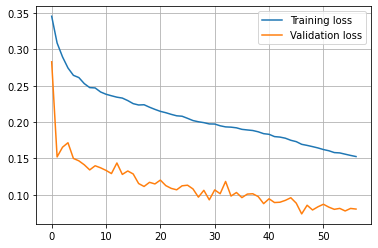

In [34]:
# running parameters 
epochs = 100
batch_size = 32

history_cnn = model_cnn.fit(x_train_cnn,
                            y_train_nn,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(x_val_cnn, y_val_nn),
                            shuffle=False,
                            callbacks=[early_stopping, weights_save])

plt.plot(history_cnn.history['loss'], label='Training loss')
plt.plot(history_cnn.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.grid()
plt.show()

model_cnn.load_weights(checkpoint_path)

### Visualize predictions

In [35]:
y_pred_cnn = model_cnn.predict(x_test_cnn)
pred_power_cnn, actual_power_cnn = invert_values(y_pred_cnn.reshape(-1, ), y_test_nn, scaler)

forecast_accuracy(pred_power_cnn, actual_power_cnn)

{'mape': inf,
 'me': -159.78777863828012,
 'mae': 186.4972003286018,
 'mpe': inf,
 'rmse': 382.16574550980545,
 'corr': 0.7681301734896574,
 'minmax': -0.1591217189202223}

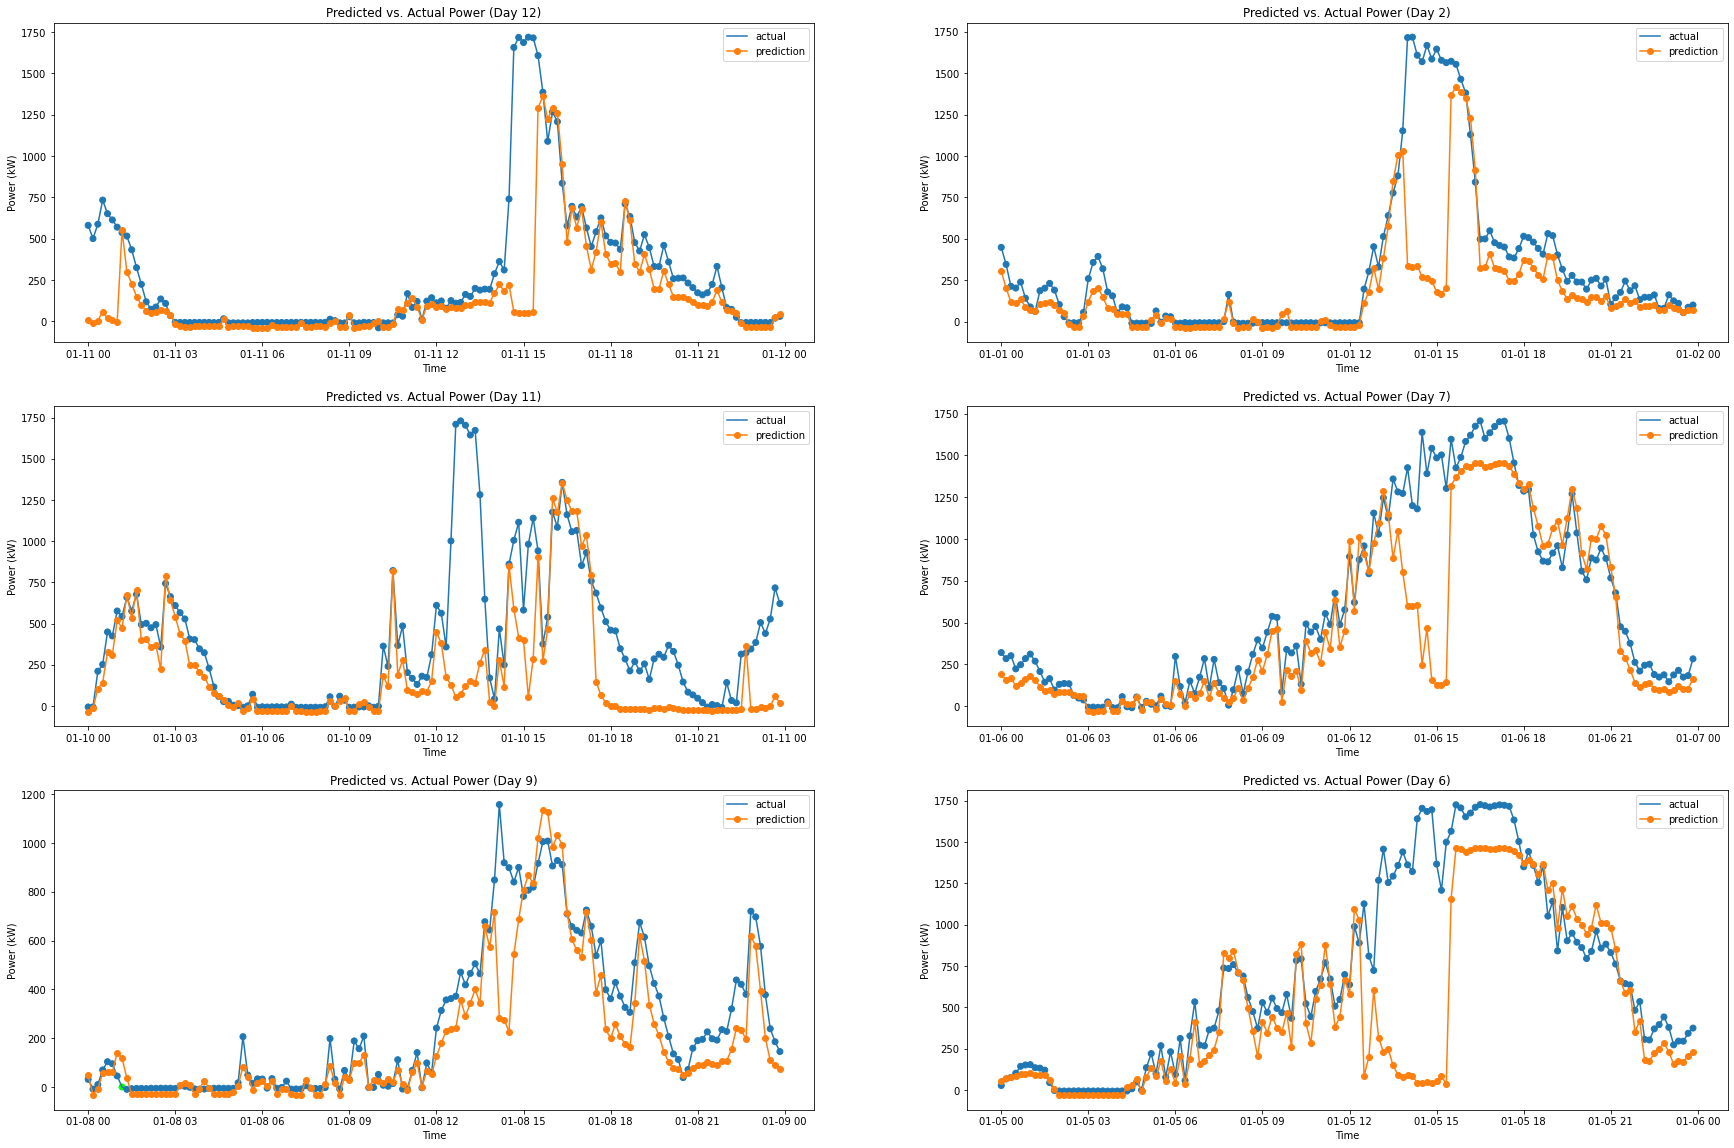

In [36]:
plot_random_predictions(pred_power_cnn, actual_power_cnn)

### Residuals

In [37]:
residuals_cnn = pd.Series(pred_power_cnn-actual_power_cnn)
residuals_cnn.describe()

count    3024.000000
mean     -159.787779
std       347.215193
min     -1760.442482
25%      -141.275892
50%       -54.040309
75%        -9.838416
max       262.153095
dtype: float64

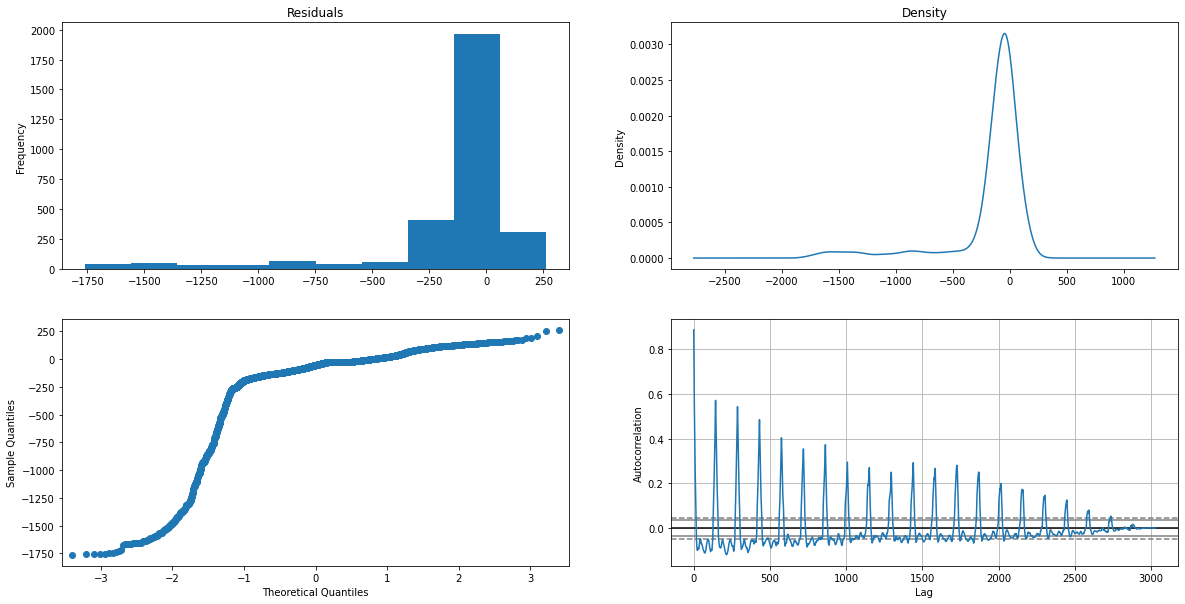

In [38]:

fig, ax = plt.subplots(2,2, figsize=(20,10))
residuals_cnn.plot(kind='hist', title="Residuals", ax=ax[0,0])
residuals_cnn.plot(kind='kde', title='Density', ax=ax[0,1])
qqplot(residuals_cnn, ax=ax[1,0])
autocorrelation_plot(residuals_cnn, ax=ax[1,1])
plt.show()

### Visualize feature maps

In [39]:
layer_outputs = [layer.output for layer in model_cnn.layers]
feature_map_model = Model(inputs=model_cnn.inputs, outputs=layer_outputs)
feature_maps = feature_map_model.predict(x_test_cnn)

In [40]:
for i, layer in enumerate(model_cnn.layers):
    if 'conv' in layer.name:
        print(i)

1
5
9
12


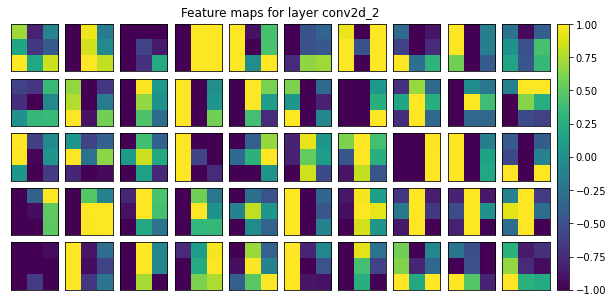

In [41]:
# convolutions at layers 1, 5, 9, ...
show_layer = 9

fig = plt.figure(figsize=(10, 5))

grid = ImageGrid(fig, 111, nrows_ncols=(5, 10), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    im = ax.imshow(feature_maps[show_layer][0, :, :, i], origin='lower', vmin=-1., vmax=1.)
    
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)

fig.suptitle(f"Feature maps for layer {model_cnn.layers[show_layer].name}", y=0.92)
plt.show()

**As it can be seen in the predictions and residuals, the CNN isn't learning well. Maybe the dimensionality of the input data is too low for a CNN, making the learning difficult for such a number of parameters. The intermediate layer do learn patterns properly, so it is working as intended. The problem is just too simple for this approach**

In [42]:
models= [[svr_model,pred_power_svr, actual_power_svr], [model_cnn,pred_power_cnn, actual_power_cnn], [model_lstm,pred_power_lstm, actual_power_lstm], [history_cnn,pred_power_cnn-actual_power_cnn]]
from sklearn.metrics import accuracy_score 
for model in models:
    accuracy= accuracy_score(model[2], model[1]) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(model[2], model[1]) # with the report, we have a bigger picture, with precision and recall for each class
    print(f"The accuracy of model {type(model[0]).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")
    forecast_accuracy(model[1], model[2])
    print("\n")


ValueError: continuous is not supported